In [1]:
%matplotlib inline
from collections import defaultdict, Counter
import glob
import os
import json

from IPython.core.display import HTML, Image
from matplotlib_venn import venn3
import pandas as pd
import pybedtools
import pysam
import gspread
from gscripts.general import parsers
from gscripts.general import dataviz
%load_ext autoreload
import numpy as np
%autoreload 2
reload(parsers)
reload(pybedtools)
import seaborn as sns
import matplotlib
from oauth2client.client import SignedJwtAssertionCredentials
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

img_dir = "/home/gpratt/Dropbox/encode_integration/for_eric/"

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [8]:
# Load eCLIP Data
final_qc_frame = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/encode_master_qc.csv", index_col=[0,1,2,3,4,5])
encode_qc = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/unannoated_encode_master_qc.csv", index_col=0)

filtered_final_qc_frame = final_qc_frame[[ "Input Reads", "Reads Written", "repetitive_count", "Reads Passing Quality Filter",
                                          "Uniquely Mapped Reads", "Uniquely mapped reads %", 'Number of reads mapped to too many loci',
                                          '% of reads unmapped: too short', '% of reads mapped to too many loci', "Usable Reads",
                                          "Fraction Collapsed", "Fraction Usable", "Num Peaks",]]

grouped_final_qc_frame = filtered_final_qc_frame.groupby(level=['rbp', 'encode_id', 'rep', 'cell_type', 'full_name']).sum()
grouped_final_qc_frame["Fraction Collapsed"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Uniquely Mapped Reads'].astype(float)
grouped_final_qc_frame["Fraction Usable"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Input Reads'].astype(float)
grouped_final_qc_frame = grouped_final_qc_frame.drop("Num Peaks", axis=1)
grouped_final_qc_frame = grouped_final_qc_frame.dropna()

encode_only_qc = grouped_final_qc_frame[[item[0].isdigit() and item[-1].isdigit() for item in grouped_final_qc_frame.index.get_level_values(level="encode_id")]]


In [9]:
# Load iCLIP data
old_encode = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/old_encode_qc.csv", index_col=0)
unmerged_old_encode_manifest = old_encode[[len(index.split(".")[1].split("_")) > 1 for index in old_encode.index]]

In [16]:
unmerged_public_iclip_manifest = pd.read_csv('/home/gpratt/Dropbox/encode_integration/for_eric/public_iclip_qc.csv', index_col=0)

In [33]:
public_clip = pd.read_csv('/home/gpratt/Dropbox/encode_integration/for_eric/public_clip_qc.csv', index_col=0)
public_iclip = pd.read_csv('/home/gpratt/Dropbox/encode_integration/for_eric/public_iclip_cleaned_qc.csv', index_col=0)

In [23]:
publication_list = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/Method_paper_figures/MethodPaperFileList_FINAL100415.txt")

In [24]:
stats_for_publication = encode_only_qc[[int(encode_id) in publication_list.uID.values for encode_id in encode_only_qc.index.get_level_values(level="encode_id")]]
stats_for_publication = stats_for_publication[["INPUT" != rep for rep in stats_for_publication.index.get_level_values(level="rep")]]
stats_for_publication = stats_for_publication.dropna()

In [25]:
real_encode_v10 = unmerged_old_encode_manifest.ix[["DirectIP" not in name for name in unmerged_old_encode_manifest.index]]
real_encode_v10 = real_encode_v10.ix[[len(name.split(".")[1].split("_")) > 1 for name in real_encode_v10.index]]
real_encode_v10 = real_encode_v10.ix[["LiCLIP" not in name for name in real_encode_v10.index]]
real_encode_v10 = real_encode_v10.ix[["ZNL" not in name for name in real_encode_v10.index]]
real_encode_v10 = real_encode_v10.ix[["ZNH" not in name for name in real_encode_v10.index]]
real_encode_v10 = real_encode_v10.ix[[not name.endswith("_a") for name in real_encode_v10.index]]
real_encode_v10 = real_encode_v10.ix[[not name.endswith("_b") for name in real_encode_v10.index]]

fus = real_encode_v10.ix[[("FUS" in name) or ("EIF4G1" in name) or ("TAL1" in name) for name in real_encode_v10.index]]

imp_data = pd.read_table("/home/gpratt/projects/encode/scripts/encode_clipseq_imp.txt", header=None, names=['path', 'species', 'merge'])
imp_data['full_name'] = imp_data.path.apply(os.path.basename).apply(lambda x: ".".join(x.split(".")[:2]))
merged_imp = pd.merge(real_encode_v10, imp_data, left_index=True, right_on="full_name")
merged_imp = merged_imp.groupby("merge").sum()

merged_imp["Fraction Collapsed"] = merged_imp['Usable Reads'] / merged_imp['Uniquely Mapped Reads'].astype(float)
merged_imp["Fraction Usable"] = merged_imp['Usable Reads'] / merged_imp['Input Reads'].astype(float)
submitted_old_encode = pd.concat([fus, merged_imp])


In [26]:
all_iclip = pd.concat([submitted_old_encode, unmerged_public_iclip_manifest])
all_iclip['annotation'] = "All iCLIP"

In [27]:
stats_for_publication['annotation'] = "ENCODE eCLIP"
submitted_old_encode['annotation'] = "ENCODE iCLIP Submitted"
#unmerged_old_encode_manifest['annotation'] = "ENCODE iCLIP"
unmerged_public_iclip_manifest['annotation'] = "Public iCLIP"
public_clip['annotation'] = "Public CLIP"

master_df = pd.concat([stats_for_publication,
                       submitted_old_encode,
                       #unmerged_old_encode_manifest,
                       unmerged_public_iclip_manifest,
                       public_clip,
                       all_iclip])

# Show that the total number of usable reads is far and away better than other non-encode stuff

In [28]:
master_df = master_df[master_df['Uniquely Mapped Reads'] > 100000]

In [29]:
master_df = master_df[[ "Input Reads",
                                #'Trimmed bases',
                            #"Reads Written",
                            #"repetitive_count",
                            "Uniquely Mapped Reads",
                            #"Uniquely mapped reads %",
                            "Usable Reads",
                            "Fraction Collapsed",
                            "Fraction Usable",
                            #"spot",
                            #"Num Peaks",
                       "annotation"
                            #"Passed QC"
                            ]]

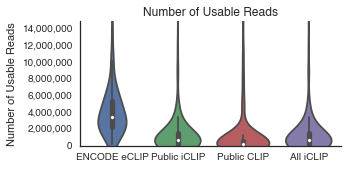

In [30]:
num_rows = 1 
num_cols = 2 
with dataviz.Figure(os.path.join(img_dir, "usable_reads_plots_publication.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot(y="Usable Reads", x="annotation", data=master_df,
                   ax=ax,
                   fontsize=10,
                  inner="box",
                   bw=.4,
                  )
    ax.set_ylim(0,15000000)
    xx = ax.get_yticks()
    ll = ['{:,d}'.format(int(a)) for a in xx]
    ax.set_yticklabels(ll, fontsize=10)
    sns.despine(ax=ax)
    ax.set_title("Number of Usable Reads", fontsize=12)
    ax.set_ylabel("Number of Usable Reads")
    ax.set_xlabel("")
    #[tick.set_rotation(90) for tick in ax.get_xticklabels()]
    #[tick.set_fontsize(8) for tick in ax.get_xticklabels()]

In [34]:
print stats_for_publication['Usable Reads'].dropna().mean(),unmerged_old_encode_manifest['Usable Reads'].dropna().mean(), public_iclip['Usable Reads'].dropna().mean(), public_clip['Usable Reads'].dropna().mean()
print stats_for_publication['Usable Reads'].dropna().median(),unmerged_old_encode_manifest['Usable Reads'].dropna().median(), public_iclip['Usable Reads'].dropna().median(), public_clip['Usable Reads'].dropna().median()

4195094.66387 1207411.0 1117863.07895 1041426.67429
3360275.0 433316.5 207549.0 191204.0


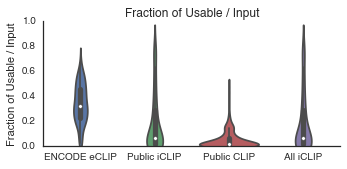

In [35]:
num_rows = 1 
num_cols = 2 
with dataviz.Figure(os.path.join(img_dir, "fraction_usable_reads_plots_publication.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot(y="Fraction Usable", x="annotation", data=master_df,
                   ax=ax,
                   fontsize=10,
                  inner="box")

    ax.set_ylim(0,1)
    #xx = ax.get_yticks()
    #ll = ['{:,d}'.format(int(a)) for a in xx]
    #ax.set_yticklabels(ll, fontsize=10)
    sns.despine(ax=ax)
    ax.set_title("Fraction of Usable / Input", fontsize=12)
    ax.set_ylabel("Fraction of Usable / Input")
    ax.set_xlabel("")

In [36]:
print stats_for_publication['Fraction Usable'].dropna().mean(), unmerged_old_encode_manifest['Fraction Usable'].dropna().mean(), public_iclip['Fraction Usable'].dropna().mean(), public_clip['Fraction Usable'].dropna().mean()
print stats_for_publication['Fraction Usable'].dropna().median(), unmerged_old_encode_manifest['Fraction Usable'].dropna().median(), public_iclip['Fraction Usable'].dropna().median(), public_clip['Fraction Usable'].dropna().median()

0.338735499478 0.163483902124 0.228532752639 0.04305766771
0.318402962709 0.131784929035 0.145375414729 0.011520680051


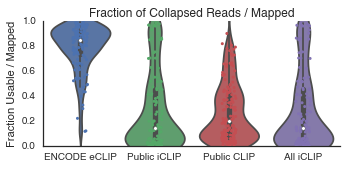

In [37]:
num_rows = 1 
num_cols = 2 
with dataviz.Figure(os.path.join(img_dir, "fraction_collapsed_reads_publication.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    sns.stripplot(y="Fraction Collapsed", x="annotation", data=master_df,
                   ax=ax,
                   #fontsize=10,
                  #inner="box",
                   # bw=.3,
                   #scale="width"
                  jitter=1,
                  edgecolor=None,
                  size=3
                  )
    sns.violinplot(y="Fraction Collapsed", x="annotation", data=master_df,
                   ax=ax,
                   fontsize=10,
                  inner="box",
                    bw=.3,
                   scale="width"
                  )
    
    ax.set_ylim(0,1)
    #xx = ax.get_yticks()
    #ll = ['{:,d}'.format(int(a)) for a in xx]
    #ax.set_yticklabels(ll, fontsize=10)
    sns.despine(ax=ax)
    ax.set_title("Fraction of Collapsed Reads / Mapped", fontsize=12)
    ax.set_ylabel("Fraction Usable / Mapped")
    ax.set_xlabel("")

In [38]:
print stats_for_publication['Fraction Collapsed'].dropna().mean(),unmerged_old_encode_manifest['Fraction Collapsed'].dropna().mean(), public_iclip['Fraction Collapsed'].dropna().mean(), public_clip['Fraction Collapsed'].dropna().mean()
print stats_for_publication['Fraction Collapsed'].dropna().median(),unmerged_old_encode_manifest['Fraction Collapsed'].dropna().median(), public_iclip['Fraction Collapsed'].dropna().median(), public_clip['Fraction Collapsed'].dropna().median()

0.791667603172 0.83315055382 0.394516165128 0.284485727844
0.854945000252 0.8623792904 0.270837383991 0.211927306048


In [39]:
len(stats_for_publication), len(submitted_old_encode), len(unmerged_old_encode_manifest), len(public_iclip), len(public_clip)

(119, 0, 36, 41, 180)

In [41]:
submitted_old_encode.to_csv('/home/gpratt/Dropbox/encode_integration/for_eric/old_encode_clips.csv')
public_clip.to_csv('/home/gpratt/Dropbox/encode_integration/for_eric/old_public_clips.csv')
public_iclip.to_csv('/home/gpratt/Dropbox/encode_integration/for_eric/old_public_iclips.csv')

In [ ]:
def join_if_tuple(item):
    if type(item) is tuple:
        return "_".join(item)
    else:
        return item
    
master_df.index = [join_if_tuple(item) for item in master_df.index]

In [42]:
pd.read_csv("/home/gpratt/Dropbox/encode_integration/for_eric/master_qc.csv")
master_df.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/master_qc.csv", sep="\t")

# Remaking data from stable qc numbers

In [43]:
master_df = pd.read_table("/home/gpratt/Dropbox/encode_integration/for_eric/master_qc_stable.csv", index_col=0)

In [44]:
public_df = master_df[(master_df.annotation != "ENCODE eCLIP") & \
                      (master_df.annotation != "ENCODE iCLIP Submitted")
                     #(master_df.annotation != "All iCLIP") \
                     ]

public_clip_df = master_df[master_df.annotation == "Public CLIP"]
public_iclip_df = master_df[master_df.annotation == "Public iCLIP"]
all_iclip_df = master_df[master_df.annotation == "All iCLIP"]

In [45]:
sup_table_1 = pd.read_excel("/home/gpratt/Dropbox/encode_integration/for_eric/SupTables/SupTable1.xlsx", "Sheet1", index_col=0)
sup_table_1_public_clip = sup_table_1[sup_table_1['experiment type (general)'] == 'Public CLIP'].copy()
sup_table_1_all_iclip = sup_table_1[sup_table_1['experiment type (general)'] == 'All iCLIP'].copy()

In [46]:
public_clip_df = sup_table_1_public_clip.join(public_clip_df)
public_iclip_df = sup_table_1.join(public_iclip_df)
all_iclip_df = sup_table_1.join(all_iclip_df)

In [47]:
set(sup_table_1['experiment type (general)'])

{u'All iCLIP', u'Public CLIP'}

In [48]:
print len(public_clip_df), len(public_clip_df.dropna())
print len(all_iclip_df), len(all_iclip_df.dropna())

152 152
279 115


In [49]:
all_iclip_df['iclip_joiner'] = all_iclip_df.RBP + all_iclip_df['Cell type']
master_df['iclip_joiner'] = [item.split("_")[0] + item.split("_")[-1] for item in master_df.index]

In [50]:
grouped_final_qc_frame['id'] = ["_".join(item) for item in grouped_final_qc_frame.index]
grouped_final_qc_frame.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/encode_v9_qc.csv")

In [51]:
analysis_dir = "/home/gpratt/projects/encode/analysis/encode_iclip_submitted_v1/"
encode_qc = parsers.clipseq_metrics(analysis_dir, iclip=False)

encode_qc["Fraction Collapsed"] = encode_qc['Usable Reads'] / encode_qc['Uniquely Mapped Reads'].astype(float)
encode_qc["Fraction Usable"] = encode_qc['Usable Reads'] / encode_qc['Input Reads'].astype(float)
#encode_qc['is_v12'] = 1

cutadapt file maybe be broken, ignoring calculation


ValueError: labels ['Finished on' 'Mapping speed, Million of reads per hour' 'Started job on'
 'Started mapping on'] not contained in axis

In [52]:
encode_qc.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/encode_iclip_submitted_qc_v12.csv")